In [22]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np 
from PIL import Image
from ultralytics import YOLO
import torch.nn as nn
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation

In [23]:
# Load a model
model = YOLO('model/yolov8n.pt')  # load an official model

processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model_cloth = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")
label_map_cloth = {0: "Background", 1: "Hat", 2: "Hair", 3: "Sunglasses", 4: "Upper-clothes", 5: "Skirt", 6: "Pants", 7: "Dress", 8: "Belt", 9: "Left-shoe", 10: "Right-shoe", 11: "Face", 12: "Left-leg", 13: "Right-leg", 14: "Left-arm", 15: "Right-arm", 16: "Bag", 17: "Scarf"}

### Pose estimation COCO
protoFile = "model/pose/coco/pose_deploy_linevec.prototxt"
weightsFile = "model/pose/coco/pose_iter_440000.caffemodel"
nPoints = 18
POSE_PAIRS = [[1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

# # Read the network into Memory 
net = cv2.dnn.readNetFromCaffe(protoFile , weightsFile) 


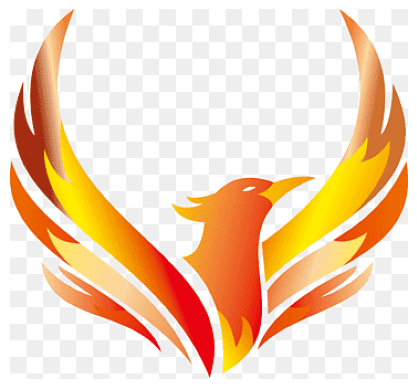

In [8]:


logo = cv2.imread('images/logo.png')
logo = cv2.cvtColor(logo, cv2.COLOR_BGR2RGB)
plt.imshow(logo)
plt.axis('off')
plt.show()

In [24]:
def modify_logo_size(logo_copy, w, h, scale=0.03): 
    '''modifies the size of the original logo based on image on which to place it, 
    whose width and height is w, h'''
    if h < w: 
        w = h 
    hlogo, wlogo = int(scale*w), int(scale*w)
    logo_copy = cv2.resize(logo_copy, 
                           (hlogo, wlogo), 
                           interpolation = cv2.INTER_LINEAR)
    return logo_copy

def find_logo_placement(shirt): 
    
    '''
    Figure out where to place the logo in a given image. 
    This is empirical and can be changed based on preference of user. 
    '''
    
    heights, widths = np.shape(shirt)
    ratio = heights/widths 
        
    if ratio > 0.8: 
        lefthalf = (widths / 2)
        lefthalf = lefthalf + (lefthalf/3)*ratio
        topfourth = heights / 4 
    else: 
        lefthalf = (widths / 2)
        lefthalf = lefthalf + (lefthalf/5.5)/ratio
        topfourth = heights / 4 / ratio
        
    return int(lefthalf), int(topfourth)

def find_logo_placement_pose(pose_information):
    
    '''
    Finds the shift in logo placement in accordance to the person's pose'''
    
    leftsx, leftsy = pose_information[0][1:]
    rightsx, rightsy = pose_information[1][1:]

    shoulder_width = rightsx - leftsx
    halfwayx = np.mean([leftsx, rightsx])
    lefthalf = halfwayx + shoulder_width // 4
    
    topfourth = rightsy + 10 
    
    return int(lefthalf), int(topfourth)

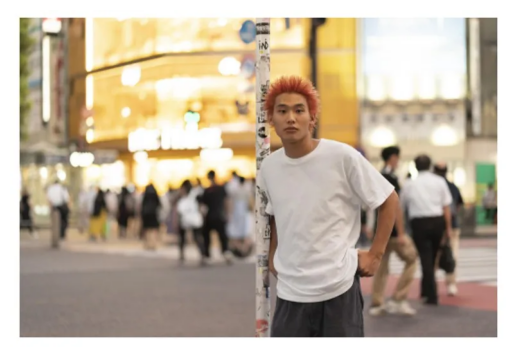

In [25]:
image_name = './images/person.webp'

image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### Show input image
plt.imshow(image)
plt.axis('off')
plt.show()


image 1/1 /home/rimsha/Desktop/360 projects/image-computer-vision/image-computer-vision-python/images/person.webp: 448x640 14 persons, 1 handbag, 68.3ms
Speed: 4.6ms preprocess, 68.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


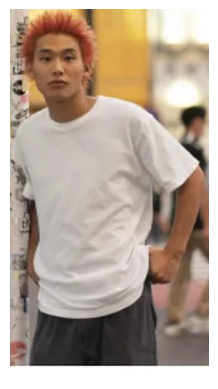

In [26]:
## Run YOLO on image to detect person
results = model(image_name)  # predict on an image

for idx, result in enumerate(results):
        
      boxes = result.boxes  # Boxes object for bounding box outputs
      names = result.names  # label map 
      
      ### To find the foreground person
      boxes_person = []
      
      for b in boxes: 

          bcls = int(b.cls.numpy()[0])
          label = names[bcls]
          if label != 'person': 
              continue 
          
          ### .conf gives us the probablity of detection
          bconf = b.conf.numpy()[0]
          x,y,w,h = b.xyxy.numpy()[0]
          
          boxes_person.append([bconf, x, y, w, h])
          
      boxes_person = np.array(boxes_person)
      max_index = np.argmax(boxes_person[:, 0])
      
      ## find the person with max prob/foreground person
      foreground_person = boxes_person[max_index].astype(int)
      x,y,w,h = foreground_person[1: ]   
          
      roi = image[y:y+h, x:w]
      
      ### Show foreground person detection boundaries
      plt.imshow(roi)
      plt.axis('off')
      plt.show()

In [33]:
## detect clothes in the foreground person 

inputs = processor(images=roi, return_tensors="pt")
outputs = model_cloth(**inputs)

# Process the output for segmentation and display it
# (This part will extract the shirt region from the person.)


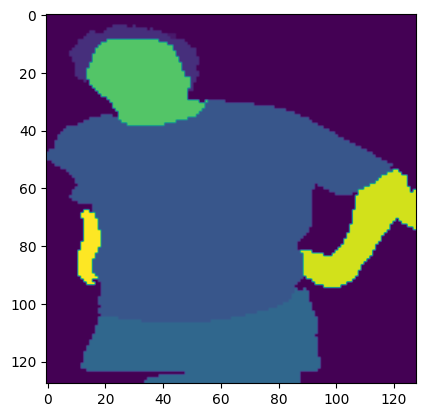

In [35]:
import torch

# Get the predicted class for each pixel (argmax over the 'num_labels' dimension)
predicted_segmentation = torch.argmax(outputs.logits, dim=1)

# Convert to numpy for further processing (if needed)
predicted_segmentation = predicted_segmentation.squeeze().cpu().numpy()
import matplotlib.pyplot as plt

# Visualize the segmentation map
plt.imshow(predicted_segmentation)
plt.show()


In [47]:
frame = roi
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1
inWidth = 368
inHeight = 368
inpBlob = cv2.dnn.blobFromImage(roi, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)
net.setInput(inpBlob)
pose_output = net.forward()

# Extract shoulder positions for logo placement
# (Assuming left shoulder = pose_output[0], right shoulder = pose_output[1])
# pose_information = [(pose_output[0][0], pose_output[0][1]), (pose_output[1][0], pose_output[1][1])]
# pose_output.shape

